In [1]:
%matplotlib inline
import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

sns.set_theme(style='whitegrid', palette='muted', font_scale=0.9)

In [2]:
with h5py.File('elm-events.hdf5', 'r') as f:
    ids = list(f.keys())
    # randomly select 5 ids
    select_5_ids = np.random.choice(ids, 5)

    # signals and times corresponding to random ids
    signals = [np.array(f[i]['signals']).T for i in select_5_ids]
    times = [np.array(f[i]['time']) for i in select_5_ids]

In [3]:
def normalize_data(signal:np.ndarray):
    assert signal.shape[1] == 64, 'Signal must be reshaped into (-1, 64)'
    signal[:, :32] = signal[:, :32] / np.max(signal[:, :32])
    signal[:, 32:] = signal[:, 32:] / np.max(signal[:, 32:])
    return signal

In [4]:
signals_normalized = [normalize_data(signal) for signal in signals]

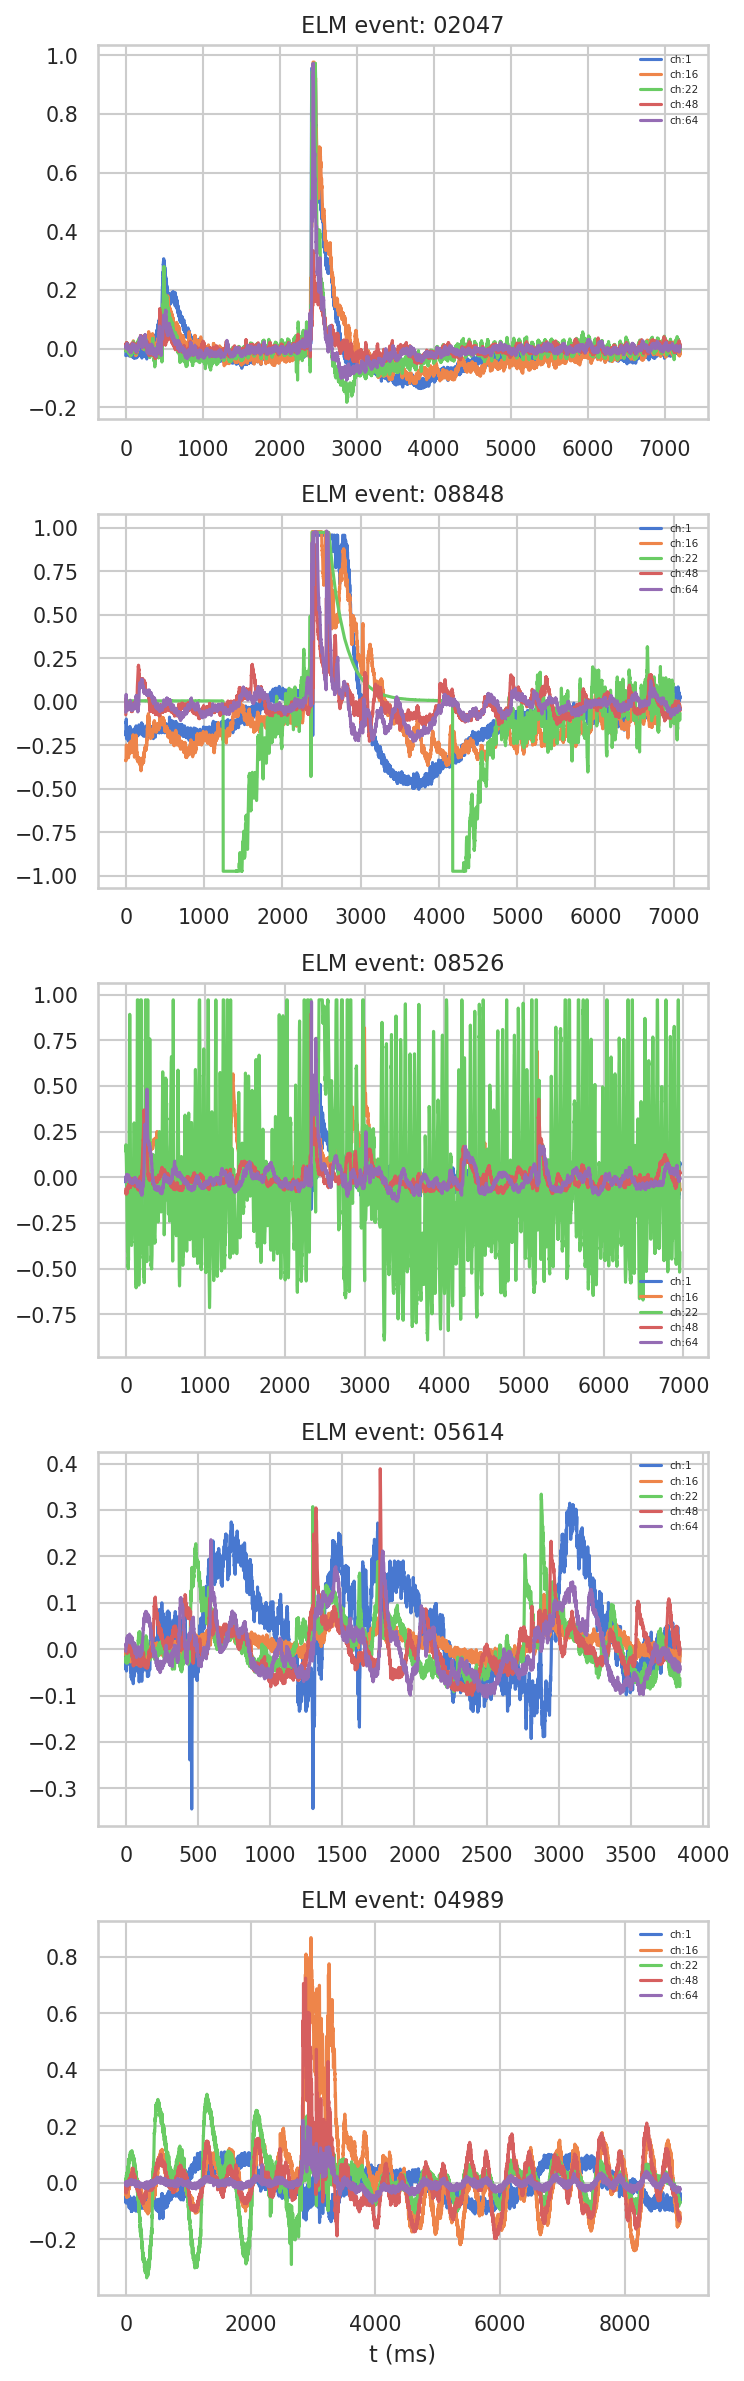

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(5, 16), dpi=150)
ax = ax.flatten()
for j, signal in enumerate(signals_normalized):
    for i in [0, 15, 21, 47, 63]:
        ax[j].plot(signal[:, i], label=f'ch:{i+1}')
        ax[j].legend(frameon=False, fontsize=5)
        ax[j].set_title(f'ELM event: {select_5_ids[j]}')
plt.xlabel('t (ms)')
plt.tight_layout()
plt.show()

In [6]:
class Encoder(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        seq_len: int,
        n_features: int,
        n_layers: int,
        dropout: float,
    ):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            batch_first=True,
            num_layers=self.n_layers,
            dropout=self.dropout,
        )

    def forward(self, x):
        _, (hidden, _) = self.rnn(x)
        # hidden size: (num_layers, batch_size, hidden_size)
        # hidden = hidden.reshape(
        #     batch_size, -1
        # )  # (batch_size, num_layers*hidden_size)
        hidden = (
            hidden.transpose(0, 1)
            .contiguous()
            .view(-1, self.n_layers * self.hidden_dim)
        )
        return hidden


class Decoder(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        seq_len: int,
        n_features: int,
        n_layers: int,
        dropout: float,
    ):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn = nn.LSTM(
            input_size=self.n_layers * self.hidden_dim,
            hidden_size=self.hidden_dim,
            batch_first=True,
            num_layers=self.n_layers,
            dropout=self.dropout,
        )
        self.fc = nn.Linear(self.hidden_dim, self.n_features)

    def forward(self, x):
        # x: (batch_size, num_layers*hidden_size)
        x = x.repeat(1, self.seq_len, 1)
        x = x.reshape(-1, self.seq_len, self.n_layers * self.hidden_dim)
        x, _ = self.rnn(x)  # x: (batch_size, seq_len, hidden_dim)
        x = self.fc(x)  # x: (batch_size, seq_len, n_features)

        return x


class LSTMAutoencoder(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions for both encoder and decoder must be equal"

        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder should have same number of layers"

    def forward(self, input):
        # input = torch.unsqueeze(input, 0)
        # encode
        hidden = self.encoder(input)
        # decode
        y = self.decoder(hidden)

        return y.squeeze(0)

In [7]:
def temporalize(sws:int, signals:np.ndarray):
    X_unlabeled = []
    for i in range(len(signals) - sws + 1):
        X_unlabeled.append(signals[i:i+sws])
    X_unlabeled = np.array(X_unlabeled)
    return X_unlabeled

In [8]:
seq_len = 16
n_features = 64
n_layers = 2
pct = 0.3
hidden_dim = 32
encoder = Encoder(
    hidden_dim=hidden_dim,
    seq_len=seq_len,
    n_features=n_features,
    n_layers=n_layers,
    dropout=pct,
)
decoder = Decoder(
    hidden_dim=hidden_dim,
    seq_len=seq_len,
    n_features=n_features,
    n_layers=n_layers,
    dropout=pct,
)
model = LSTMAutoencoder(encoder, decoder)
model

LSTMAutoencoder(
  (encoder): Encoder(
    (rnn): LSTM(64, 32, num_layers=2, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (rnn): LSTM(64, 32, num_layers=2, batch_first=True, dropout=0.3)
    (fc): Linear(in_features=32, out_features=64, bias=True)
  )
)

In [9]:
base_path = os.path.dirname(os.getcwd())
saved_model_path = 'elm_classification/model_checkpoints/signal_window_16/lstm_ae_sws_16_la_0.pth'
model_ckpt_path = os.path.join(base_path, saved_model_path)
print(f'Loading model from:\n{model_ckpt_path}')
device = torch.device("cpu")
model = model.to(device)
model.load_state_dict(
        torch.load(
            model_ckpt_path,
            map_location=device,
        )
    )

Loading model from:
/home/lakshya/research/bes_edgeml_models/elm_classification/model_checkpoints/signal_window_16/lstm_ae_sws_16_la_0.pth


<All keys matched successfully>

In [23]:
X_unlabeled = temporalize(sws=seq_len, signals=signals_normalized[0])
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [24]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

# threshold = 0.026
threshold = 0.06
error_df = pd.DataFrame(
        {
            "reconstruction_error": mae,
            "reconstruction_error_scaled": mae / np.max(mae),
            "ch_22": sequences,
        }
    )
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.007934,0.012996,-0.009259,0
1,0.008446,0.013834,-0.000356,0
2,0.008827,0.014458,0.004155,0
3,0.009023,0.014779,0.006291,0
4,0.008866,0.014521,0.010090,0
...,...,...,...,...
7181,0.008430,0.013808,0.015551,0
7182,0.009503,0.015564,0.009734,0
7183,0.008914,0.014601,0.010565,0
7184,0.008841,0.014481,0.016856,0


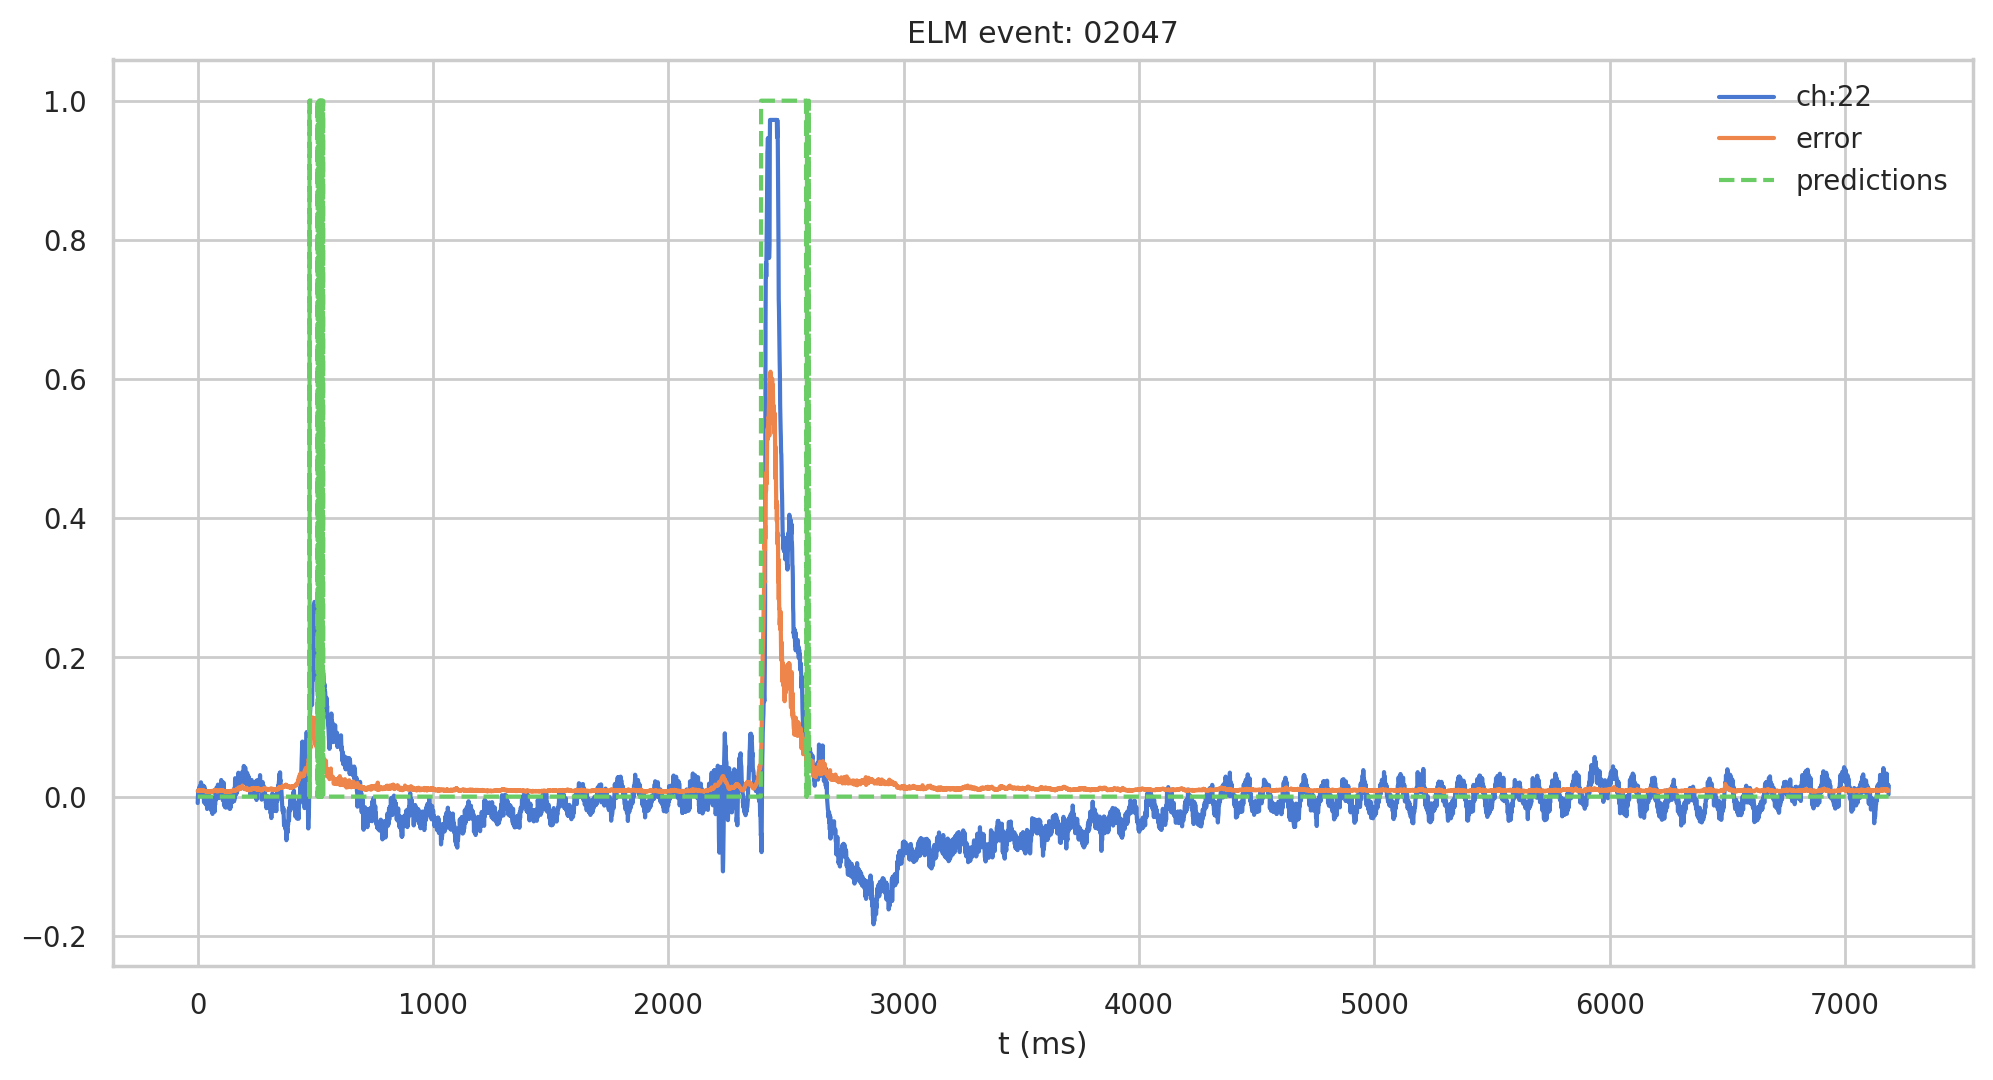

In [25]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title(f'ELM event: {select_5_ids[0]}')
plt.xlabel('t (ms)')
plt.show();

In [26]:
predictions = error_df['predictions'].values
fixed_predictions = np.zeros_like(predictions, dtype=np.int16)
non_zero_idx = np.where(predictions > 0)[0]

In [27]:
pd.DataFrame({'index': non_zero_idx, 'diff': np.diff(non_zero_idx, append=np.nan)})

,index,diff
0,475,2.0
1,477,1.0
2,478,1.0
3,479,1.0
4,480,1.0
...,...,...
235,2583,1.0
236,2584,1.0
237,2585,4.0
238,2589,8.0


In [28]:
idx_diff = np.diff(non_zero_idx, append=np.nan)

In [29]:
active_elm_end = np.where(idx_diff > 25)[0][0]

In [30]:
active_elm_idx = non_zero_idx[:active_elm_end]#np.where(idx_diff <= 10)[0]]

In [31]:
fixed_predictions[active_elm_idx] = 1

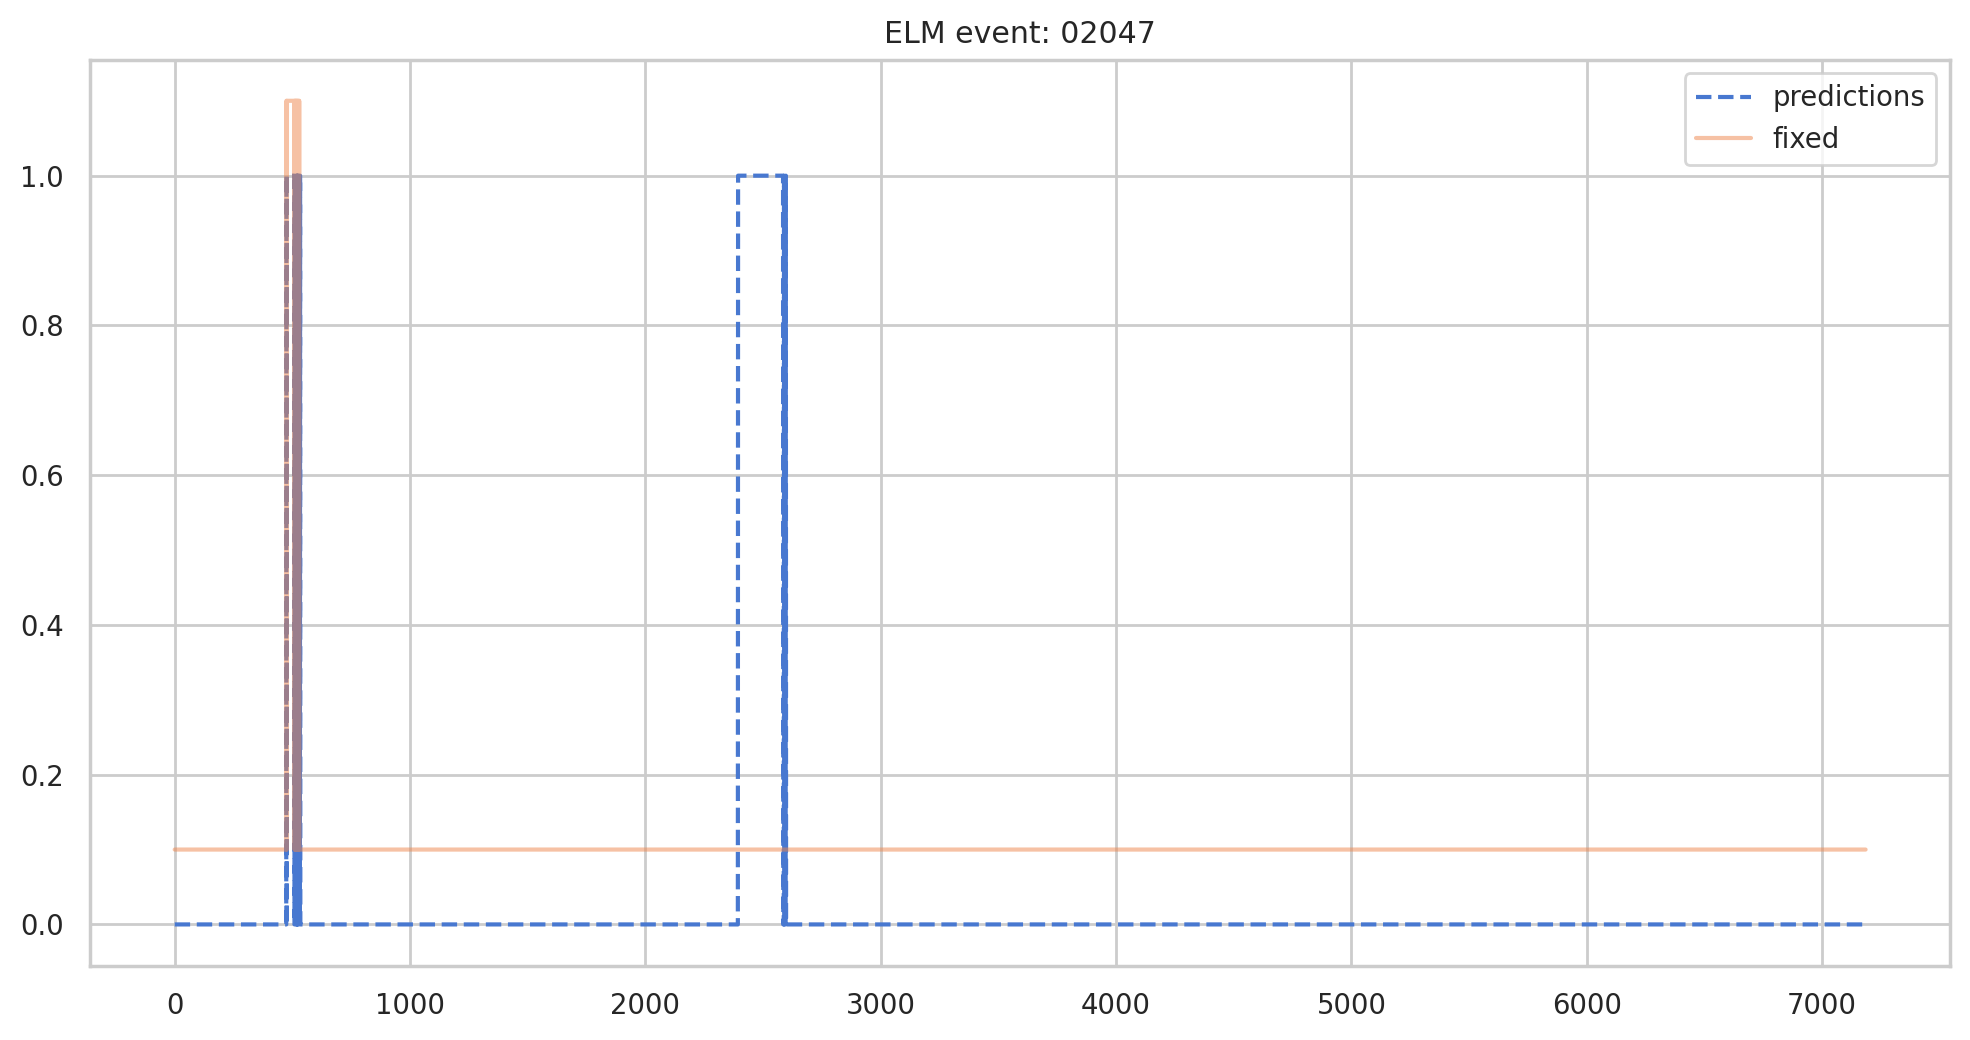

In [32]:
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(predictions, ls='--', label='predictions')
plt.plot(fixed_predictions+0.1, alpha=0.5, label='fixed')
plt.title(f'ELM event: {select_5_ids[0]}')
plt.legend()
plt.show()

In [33]:
X_unlabeled = temporalize(sws=seq_len, signals=signals_normalized[1])
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [34]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

threshold = 0.06
error_df = pd.DataFrame(
        {
            "reconstruction_error": mae,
            "reconstruction_error_scaled": mae / np.max(mae),
            "ch_22": sequences,
        }
    )
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.102606,0.121293,0.005579,1
1,0.100891,0.119266,0.005698,1
2,0.095449,0.112833,0.005460,1
3,0.090677,0.107192,0.005698,1
4,0.083467,0.098669,0.005460,1
...,...,...,...,...
7061,0.029658,0.035059,-0.080245,0
7062,0.031190,0.036870,-0.070274,0
7063,0.030925,0.036557,-0.043328,0
7064,0.029389,0.034741,-0.029439,0


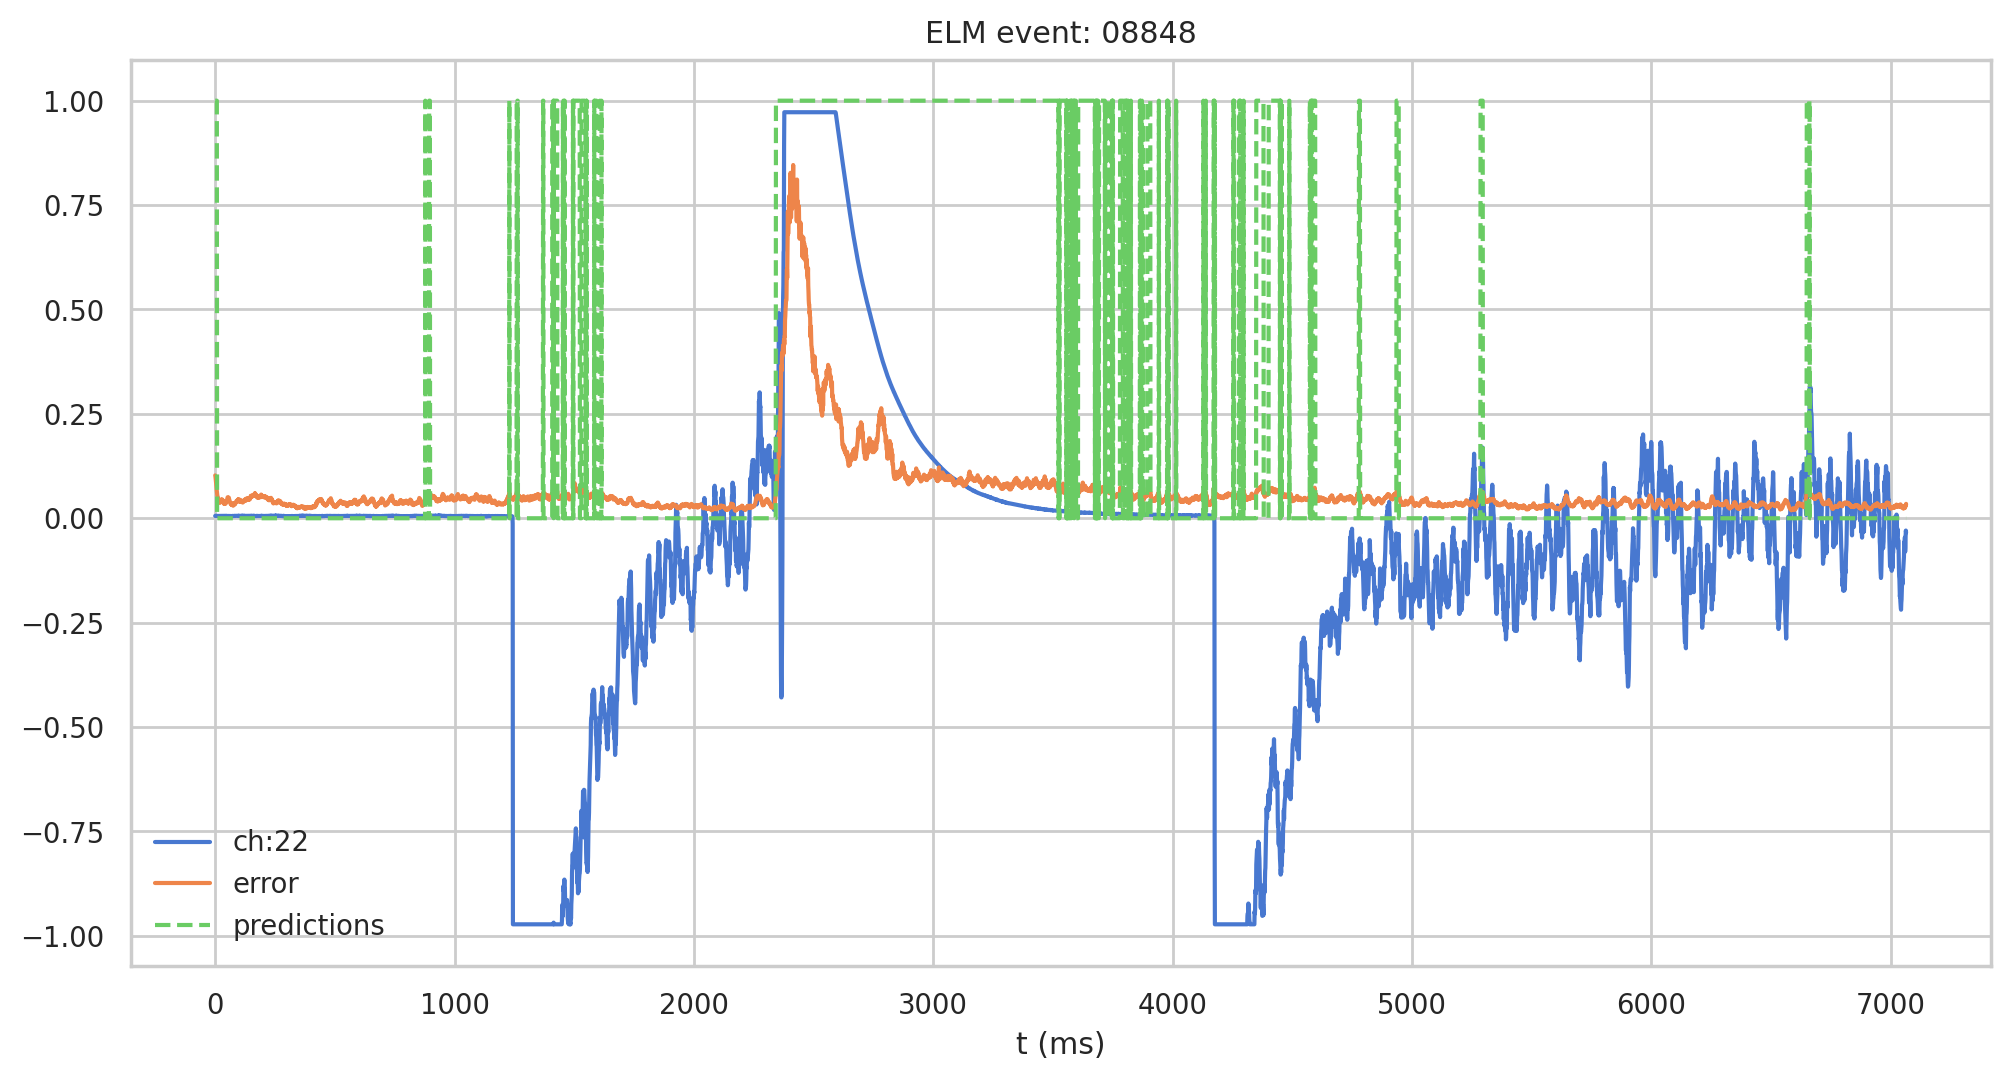

In [35]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title(f'ELM event: {select_5_ids[1]}')
plt.xlabel('t (ms)')
plt.show()

In [36]:
X_unlabeled = temporalize(sws=seq_len, signals=signals_normalized[2])
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [37]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

# threshold = 0.026
threshold = 0.06
error_df = pd.DataFrame(
    {
        "reconstruction_error": mae,
        "reconstruction_error_scaled": mae / np.max(mae),
        "ch_22": sequences,
    }
)
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.048490,0.155975,0.142566,0
1,0.049262,0.158458,0.167732,0
2,0.048942,0.157429,0.178534,0
3,0.053883,0.173323,0.174142,0
4,0.052193,0.167886,0.136987,0
...,...,...,...,...
6941,0.125444,0.403509,0.952735,1
6942,0.126161,0.405815,0.773845,1
6943,0.117343,0.377452,0.568840,1
6944,0.120583,0.387874,0.392205,1


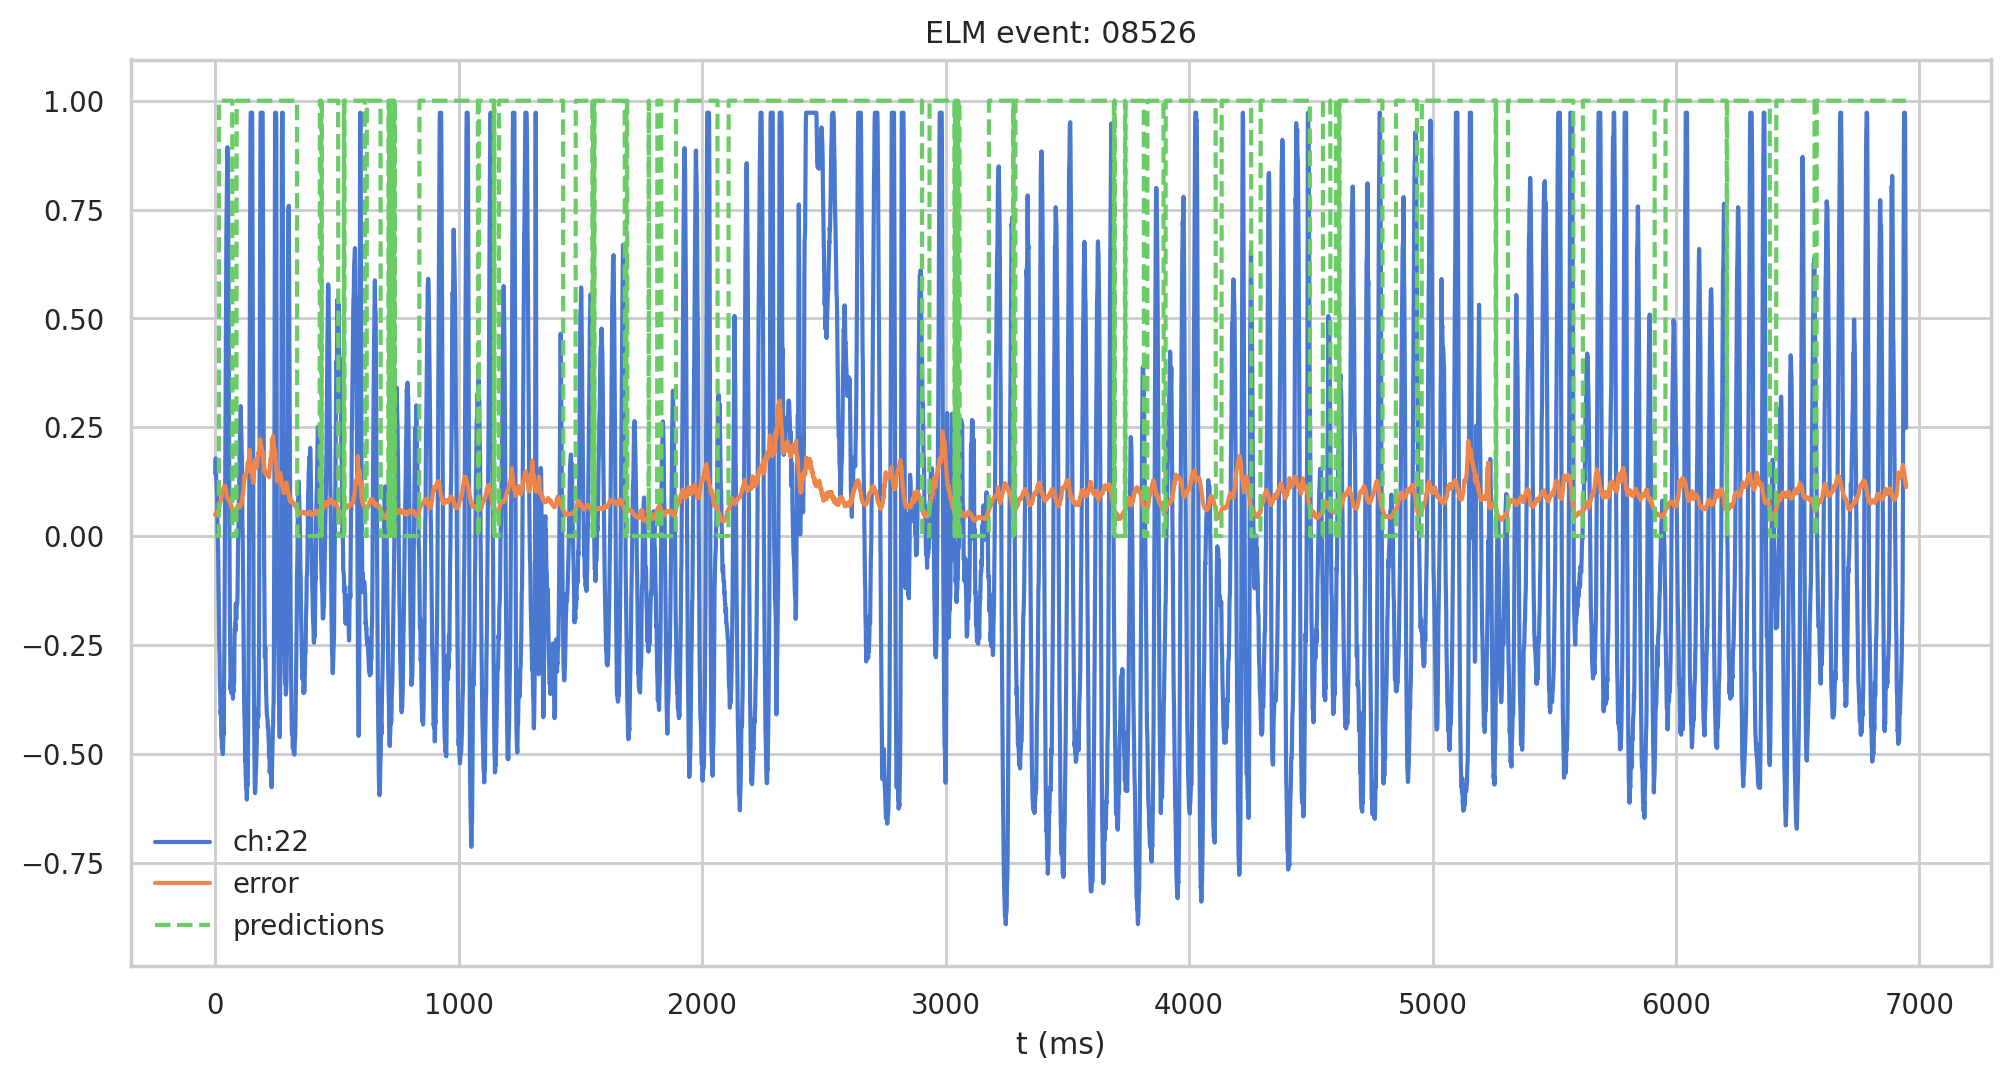

In [38]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title(f'ELM event: {select_5_ids[2]}')
plt.xlabel('t (ms)')
plt.show()

In [39]:
X_unlabeled = temporalize(sws=seq_len, signals=signals_normalized[3])
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [40]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

# threshold = 0.026
threshold = 0.06
error_df = pd.DataFrame(
    {
        "reconstruction_error": mae,
        "reconstruction_error_scaled": mae / np.max(mae),
        "ch_22": sequences,
    }
)
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.073113,0.303324,-0.018065,1
1,0.073831,0.306302,-0.021050,1
2,0.074980,0.311068,-0.029709,1
3,0.075322,0.312487,-0.020603,1
4,0.074862,0.310576,-0.016870,1
...,...,...,...,...
3821,0.053765,0.223055,-0.060315,0
3822,0.051380,0.213161,-0.067182,0
3823,0.046865,0.194427,-0.074199,0
3824,0.046231,0.191797,-0.062256,0


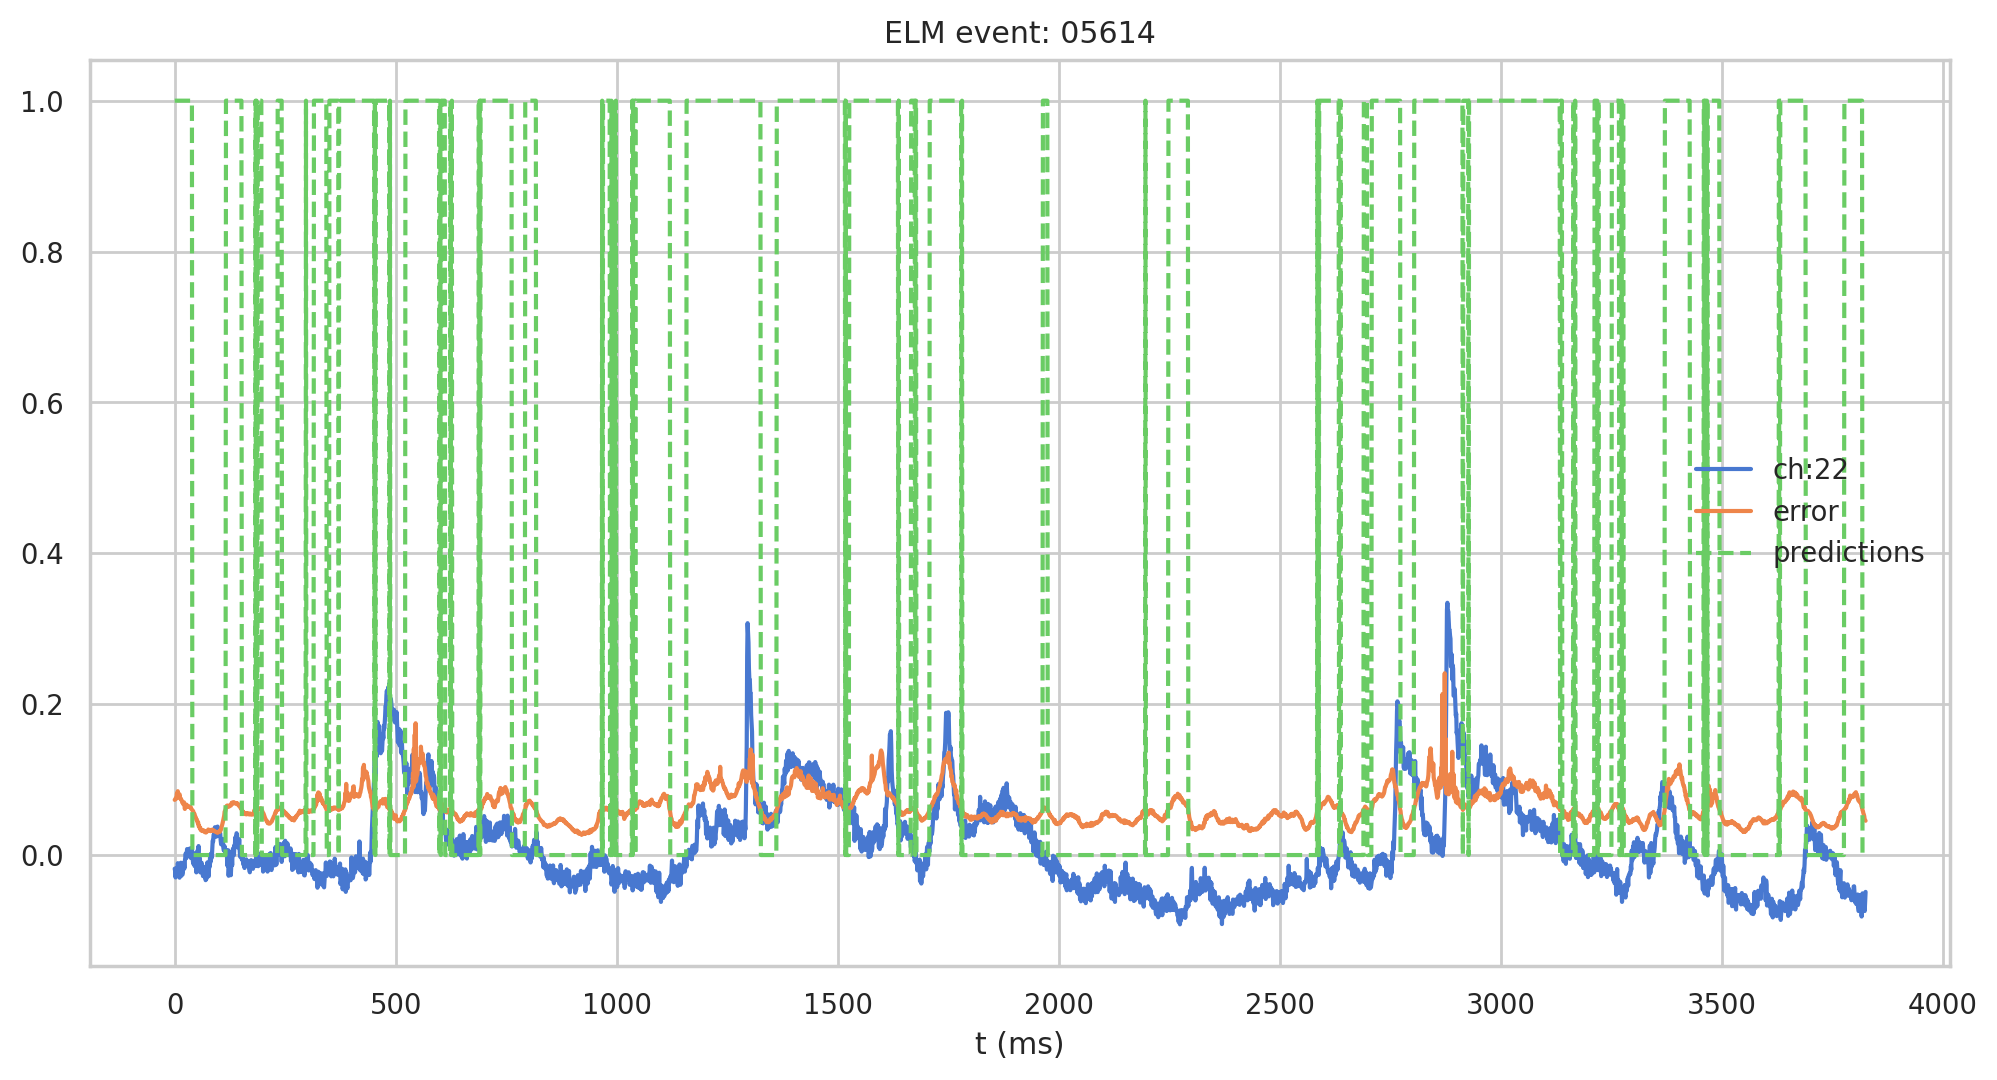

In [41]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title(f'ELM event: {select_5_ids[3]}')
plt.xlabel('t (ms)')
plt.show()